# Проект: Рекомендательная система событий

**Цель проекта:** Разработка рекомендательной системы для предсказания заинтересованности пользователей в онлайн-событиях.

**Описание:** В этом проекте мы строим рекомендательную систему, используя данные о пользователях, событиях и их взаимодействиях.
Система должна предсказывать, какие события могут быть интересны пользователю, основываясь на его профиле и характеристиках событий.

**Этапы проекта:**

1. **Загрузка данных:** Загрузка всех необходимых датасетов из CSV файлов.
2. **Исследовательский анализ данных (EDA):** Предварительное изучение данных для понимания их структуры, типов данных, пропусков и основных статистик.
3. **Feature Engineering:** Создание новых признаков на основе имеющихся данных, которые могут улучшить качество модели. Включает в себя создание временных признаков, признаков популярности событий и т.д.
4. **Подготовка данных для моделирования:**  Предобработка данных, кодирование категориальных признаков, разделение на обучающую и валидационную выборки, обработка пропусков и дисбаланса классов.
5. **Обучение и оценка моделей:** Обучение нескольких моделей машинного обучения (логистическая регрессия, случайный лес, LightGBM) и оценка их качества на валидационной выборке с использованием метрик классификации (AUC-ROC, Classification Report) и метрики ранжирования (MAP@200).
6. **Реализация функции рекомендации:** Создание функции, которая для заданного пользователя возвращает список рекомендованных событий.
7. **Создание Submission файла:** Формирование файла submission в формате, требуемом для соревнования Kaggle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Загрузка данных

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
events_df = pd.read_csv('data/events.csv')
users_df = pd.read_csv('data/users.csv')
event_attendees_df = pd.read_csv('data/event_attendees.csv')

## 2. Исследовательский анализ данных (EDA)

### 2.1. Предварительный просмотр данных"

In [3]:
print("Train data:")
display(train_df.head())
print("\nEvents data:")
display(events_df.head())
print("\nUsers data:")
display(users_df.head())
print("\nAttendees data:")
display(event_attendees_df.head())

Train data:


,user,event,invited,timestamp,interested,not_interested
0,3044012,1918771225,0,2012-10-02 15:53:05.754000+00:00,0,0
1,3044012,1502284248,0,2012-10-02 15:53:05.754000+00:00,0,0
2,3044012,2529072432,0,2012-10-02 15:53:05.754000+00:00,1,0
3,3044012,3072478280,0,2012-10-02 15:53:05.754000+00:00,0,0
4,3044012,1390707377,0,2012-10-02 15:53:05.754000+00:00,0,0



Events data:


,event_id,user_id,start_time,city,state,zip,country,lat,lng,c_1,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,684921758,3647864012,2012-10-31T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,1,0,0,0,0,0,0,0,9
1,244999119,3476440521,2012-11-03T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,7
2,3928440935,517514445,2012-11-05T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,12
3,2582345152,781585781,2012-10-30T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,8
4,1051165850,1016098580,2012-09-27T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,9



Users data:


,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0



Attendees data:


,event,yes,maybe,invited,no
0,1159822043,1975964455 252302513 4226086795 3805886383 142...,2733420590 517546982 1350834692 532087573 5831...,1723091036 3795873583 4109144917 3560622906 31...,3575574655 1077296663
1,686467261,2394228942 2686116898 1056558062 3792942231 41...,1498184352 645689144 3770076778 331335845 4239...,1788073374 733302094 1830571649 676508092 7081...,NaN
2,1186208412,NaN,3320380166 3810793697,1379121209 440668682,1728988561 2950720854
3,2621578336,NaN,NaN,NaN,NaN
4,855842686,2406118796 3550897984 294255260 1125817077 109...,2671721559 1761448345 2356975806 2666669465 10...,1518670705 880919237 2326414227 2673818347 332...,3500235232


### 2.2. Описательная статистика и информация о типах данных

In [4]:
print("Train data info:")
print(train_df.info())
print("\nTrain data describe:")
display(train_df.describe())

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15398 entries, 0 to 15397
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user            15398 non-null  int64 
 1   event           15398 non-null  int64 
 2   invited         15398 non-null  int64 
 3   timestamp       15398 non-null  object
 4   interested      15398 non-null  int64 
 5   not_interested  15398 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 721.9+ KB
None

Train data describe:


,user,event,invited,interested,not_interested
count,1.539800e+04,1.539800e+04,15398.000000,15398.000000,15398.000000
mean,2.199685e+09,2.060937e+09,0.042473,0.268282,0.033381
std,1.268887e+09,1.190660e+09,0.201672,0.443079,0.179635
min,3.044012e+06,1.040700e+05,0.000000,0.000000,0.000000
25%,1.071319e+09,1.057229e+09,0.000000,0.000000,0.000000
50%,2.259555e+09,1.996503e+09,0.000000,0.000000,0.000000
75%,3.292836e+09,3.060446e+09,0.000000,1.000000,0.000000
max,4.293103e+09,4.294677e+09,1.000000,1.000000,1.000000


In [5]:
print("Events data info:")
display(events_df.info())
print("\nEvents data describe:")
display(events_df.describe())


Events data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137972 entries, 0 to 3137971
Columns: 110 entries, event_id to c_other
dtypes: float64(2), int64(103), object(5)
memory usage: 2.6+ GB


None


Events data describe:


,event_id,user_id,lat,lng,c_1,c_2,c_3,c_4,c_5,c_6,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
count,3.137972e+06,3.137972e+06,1.806092e+06,1.806092e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,...,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06,3.137972e+06
mean,2.147180e+09,2.114831e+09,3.393515e+01,-5.748120e+01,2.324834e+00,1.692952e+00,1.451996e+00,1.071046e+00,1.051598e+00,9.937807e-01,...,7.908739e-02,8.298417e-02,6.359872e-02,8.168365e-02,7.978465e-02,7.888503e-02,7.959695e-02,7.917598e-02,7.789649e-02,4.173811e+01
std,1.239951e+09,1.264534e+09,1.897208e+01,6.540928e+01,4.095202e+00,2.845647e+00,2.612183e+00,1.904300e+00,2.283144e+00,3.456083e+00,...,3.426288e-01,3.665797e-01,3.011689e-01,3.286883e-01,3.926603e-01,1.068604e+00,3.399542e-01,4.278229e-01,3.453929e-01,4.939340e+01
min,9.200000e+01,5.660000e+02,-8.615100e+01,-1.764570e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.073168e+09,9.866086e+08,3.286500e+01,-9.714500e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01
50%,2.147012e+09,2.104379e+09,3.964100e+01,-7.946400e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01
75%,3.220719e+09,3.216721e+09,4.335900e+01,-4.764750e+00,3.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e+01
max,4.294964e+09,4.294966e+09,7.821800e+01,1.793170e+02,2.186000e+03,3.010000e+02,2.530000e+02,2.080000e+02,1.801000e+03,5.050000e+02,...,2.000000e+01,2.500000e+01,9.100000e+01,2.100000e+01,4.500000e+01,1.801000e+03,1.900000e+01,3.600000e+01,4.100000e+01,9.664000e+03


In [6]:
print("\n#### Users data info:")
display(users_df.info())
print("\n#### Users data describe:")
display(users_df.describe(include='all'))


#### Users data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    38209 non-null  int64  
 1   locale     38209 non-null  object 
 2   birthyear  36717 non-null  object 
 3   gender     38100 non-null  object 
 4   joinedAt   38151 non-null  object 
 5   location   32744 non-null  object 
 6   timezone   37773 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


None


#### Users data describe:


,user_id,locale,birthyear,gender,joinedAt,location,timezone
count,3.820900e+04,38209,36717,38100,38151,32744,37773.000000
unique,NaN,64,97,2,38151,2803,NaN
top,NaN,en_US,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,NaN
freq,NaN,17073,3915,23242,1,4509,NaN
mean,2.150982e+09,NaN,NaN,NaN,NaN,NaN,110.161226
std,1.242134e+09,NaN,NaN,NaN,NaN,NaN,359.604823
min,6.110000e+03,NaN,NaN,NaN,NaN,NaN,-720.000000
25%,1.072041e+09,NaN,NaN,NaN,NaN,NaN,-240.000000
50%,2.153423e+09,NaN,NaN,NaN,NaN,NaN,240.000000
75%,3.222394e+09,NaN,NaN,NaN,NaN,NaN,420.000000


In [7]:
print("\n#### Event attendees data info:")
display(event_attendees_df.info())
print("\n#### Event attendees data describe:")
display(event_attendees_df.describe(include='all'))


#### Event attendees data info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24144 entries, 0 to 24143
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   event    24144 non-null  int64 
 1   yes      22160 non-null  object
 2   maybe    20977 non-null  object
 3   invited  22322 non-null  object
 4   no       17485 non-null  object
dtypes: int64(1), object(4)
memory usage: 943.2+ KB


None


#### Event attendees data describe:


,event,yes,maybe,invited,no
count,2.414400e+04,22160,20977,22322,17485
unique,NaN,22130,20961,22298,17375
top,NaN,1505206691,3564347245,4161743494 924294113,4050161318
freq,NaN,3,3,3,3
mean,2.152309e+09,NaN,NaN,NaN,NaN
std,1.235844e+09,NaN,NaN,NaN,NaN
min,8.765000e+04,NaN,NaN,NaN,NaN
25%,1.088731e+09,NaN,NaN,NaN,NaN
50%,2.152438e+09,NaN,NaN,NaN,NaN
75%,3.218611e+09,NaN,NaN,NaN,NaN


### 2.3. Визуализация распределения числовых признаков

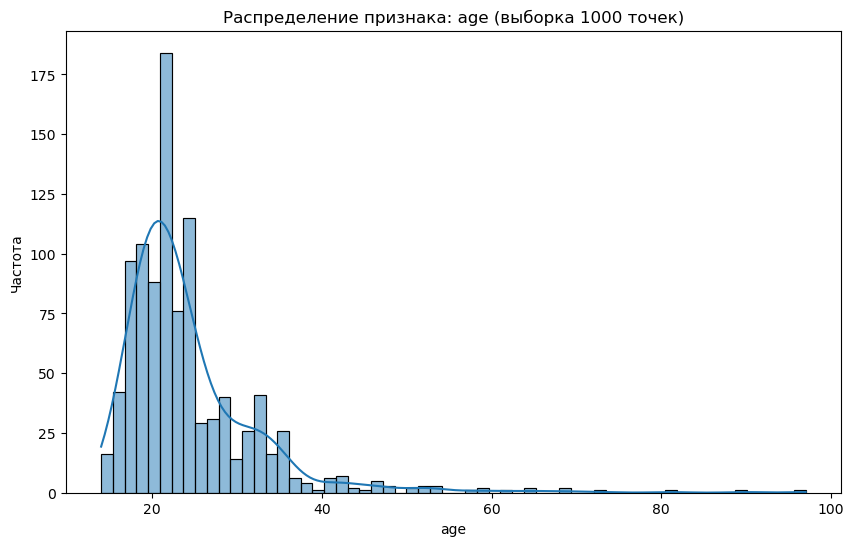

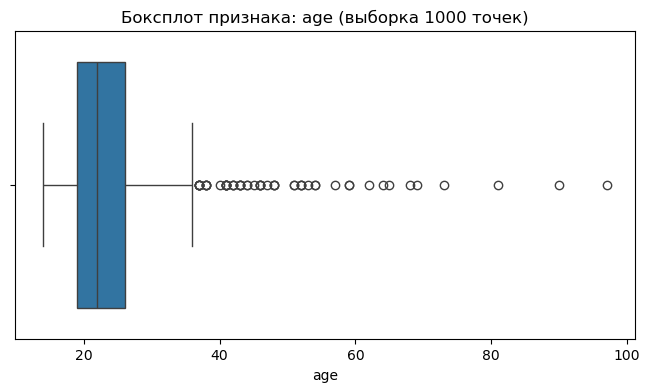

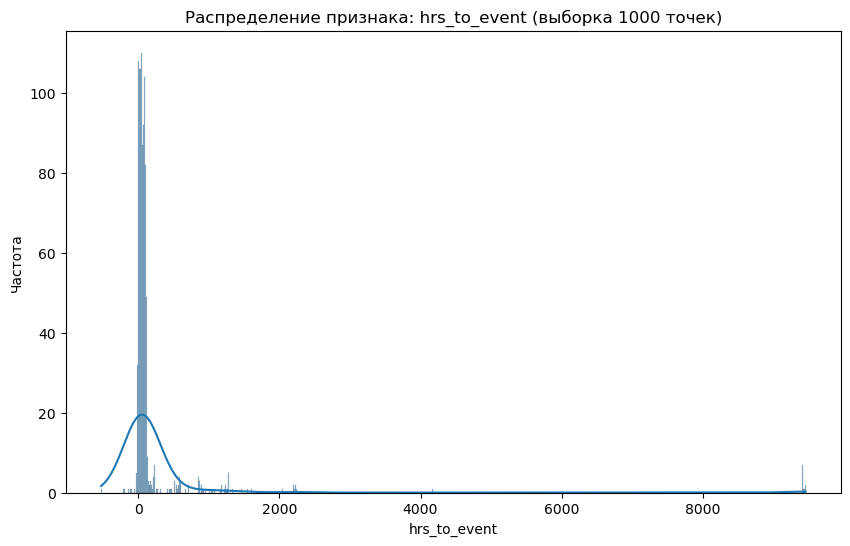

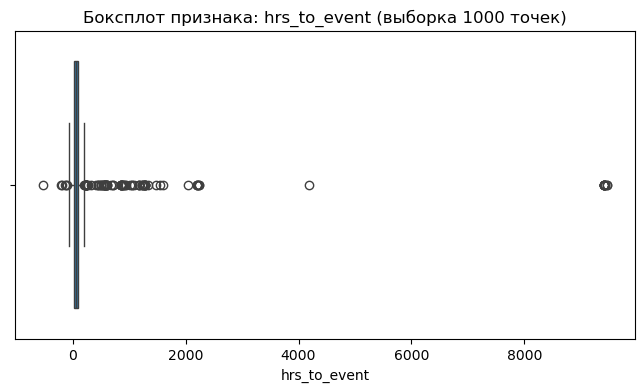

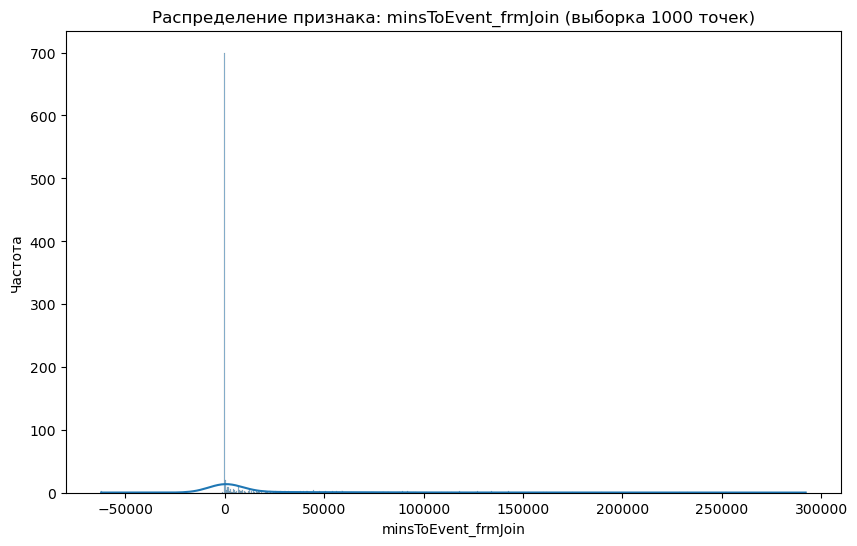

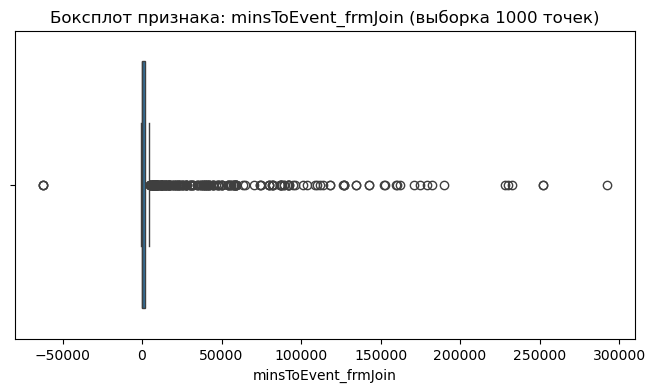

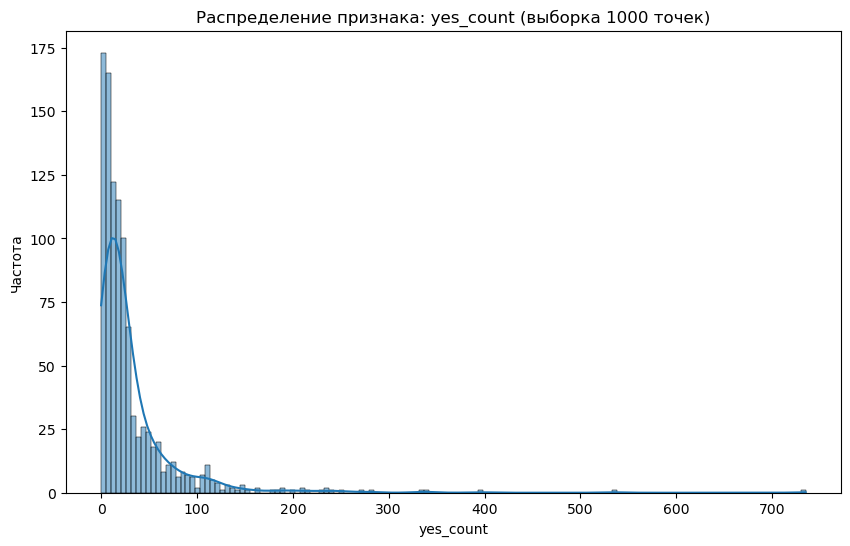

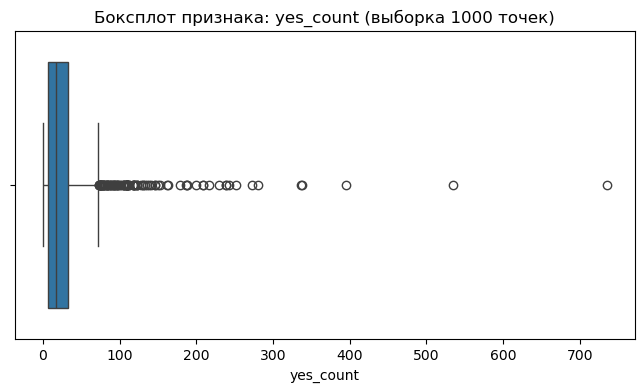

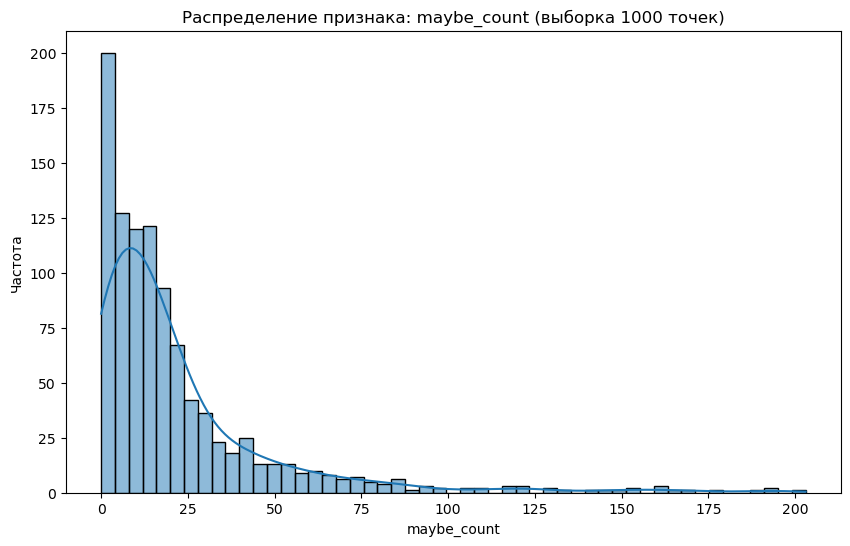

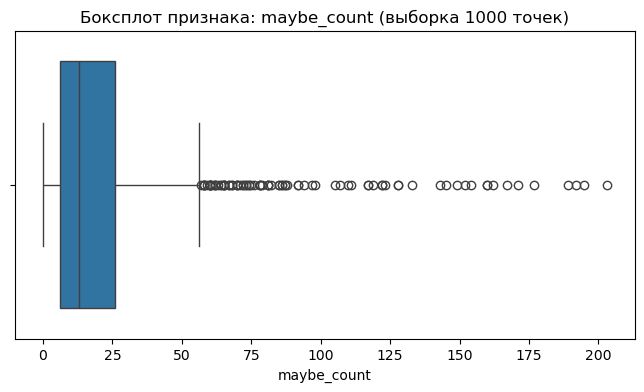

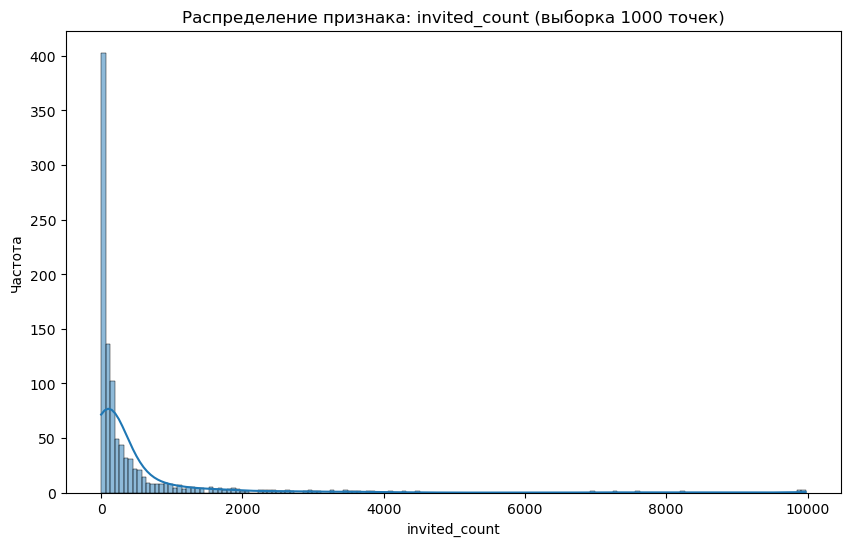

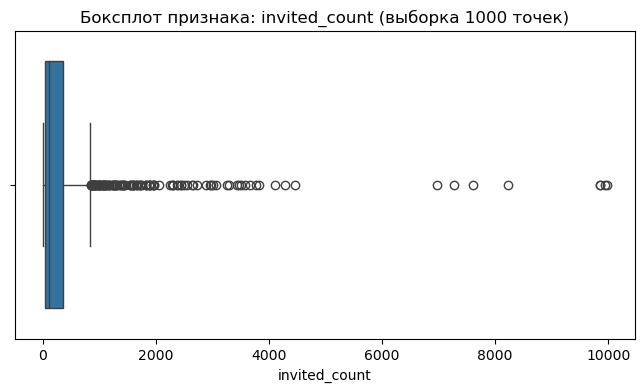

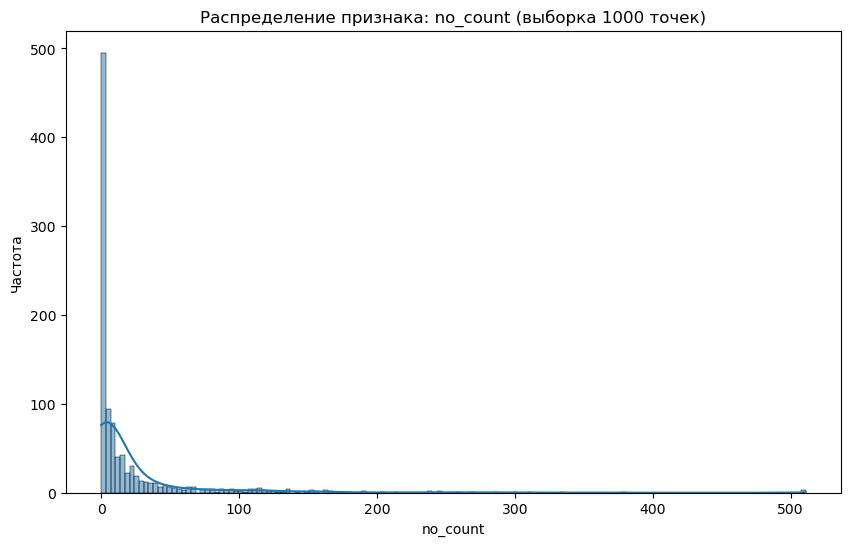

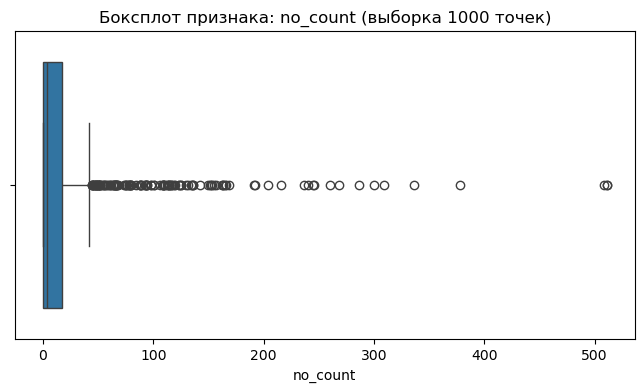

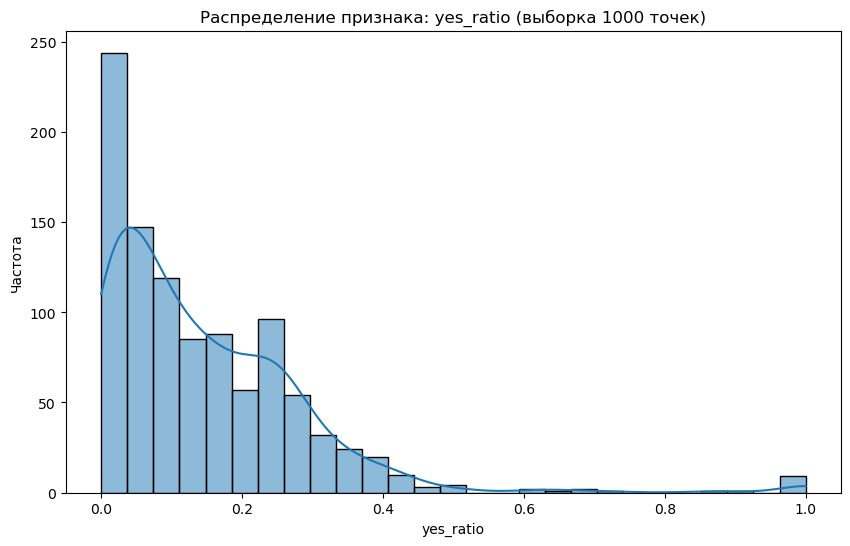

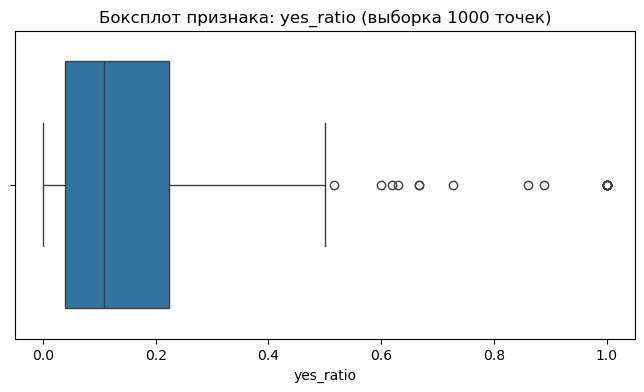

In [26]:
# attendance_rate', 'event_start_hour', 'user_joined_month', 'user_joined_year'
numerical_features_eda = ['age', 'hrs_to_event', 'minsToEvent_frmJoin', 'yes_count', 'maybe_count', 'invited_count', 'no_count', 'yes_ratio', ] # Список числовых признаков для EDA
sample_size_eda = 1000 # Устанавливаем размер выборки для EDA (например, 10000 точек)

for feature in numerical_features_eda:
    if feature in users_df.columns:
        df = users_df
    elif feature in events_df.columns:
        df = events_df
    elif feature in train_df.columns:
        df = train_df
    else:
        continue

    plt.figure(figsize=(10, 6))
    sample_data = df[feature].dropna().sample(n=min(sample_size_eda, len(df)), random_state=42) # Берем случайную выборку, не больше sample_size_eda и не больше размера данных
    sns.histplot(sample_data, kde=True) # Строим гистограмму на основе выборки
    plt.title(f'Распределение признака: {feature} (выборка {len(sample_data)} точек)') # Обновленный заголовок с указанием размера выборки
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(8, 4))
    sample_data_boxplot = df[feature].dropna().sample(n=min(sample_size_eda, len(df)), random_state=42) # Берем случайную выборку и для боксплота
    sns.boxplot(x=sample_data_boxplot) # Строим боксплот на основе выборки
    plt.title(f'Боксплот признака: {feature} (выборка {len(sample_data_boxplot)} точек)') # Обновленный заголовок
    plt.xlabel(feature)
    plt.show()

## 3. Feature Engineering

### 3.1. Преобразование типов данных

In [9]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], utc=True, format='ISO8601')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], utc=True, format='ISO8601')
events_df['start_time'] = pd.to_datetime(events_df['start_time'], utc=True, format='ISO8601', errors='coerce')
users_df['joinedAt'] = pd.to_datetime(users_df['joinedAt'], utc=True, format='ISO8601')
users_df['birthyear'] = pd.to_numeric(users_df['birthyear'], errors='coerce')

### 3.2. Создание признаков на основе времени

In [10]:
current_year = 2013
users_df['age'] = current_year - users_df['birthyear']
events_df['event_start_weekday'] = events_df['start_time'].dt.weekday
events_df['event_start_hour'] = events_df['start_time'].dt.hour
users_df['user_joined_month'] = users_df['joinedAt'].dt.month
users_df['user_joined_year'] = users_df['joinedAt'].dt.year

In [11]:
# Feature 1: Время до начала события в часах (hrs_to_event)
train_df_merged_time = pd.merge(train_df, events_df[['event_id', 'start_time']], left_on='event', right_on='event_id', how='left').drop('event_id', axis=1)
train_df_merged_time['hrs_to_event'] = (train_df_merged_time['start_time'] - train_df_merged_time['timestamp']).dt.total_seconds() / 3600
train_df = train_df_merged_time.drop(columns=['start_time'])

test_df_merged_time = pd.merge(test_df, events_df[['event_id', 'start_time']], left_on='event', right_on='event_id', how='left').drop('event_id', axis=1)
test_df_merged_time['hrs_to_event'] = (test_df_merged_time['start_time'] - test_df_merged_time['timestamp']).dt.total_seconds() / 3600
test_df = test_df_merged_time.drop(columns=['start_time'])

In [12]:
# Feature 2: Время с момента присоединения пользователя до просмотра события в минутах (minsToEvent_frmJoin)
train_df_merged_join_time = pd.merge(train_df, users_df[['user_id', 'joinedAt']], left_on='user', right_on='user_id', how='left').drop('user_id', axis=1)
train_df_merged_join_time['minsToEvent_frmJoin'] = (train_df_merged_join_time['timestamp'] - train_df_merged_join_time['joinedAt']).dt.total_seconds() / 60
train_df = train_df_merged_join_time.drop(columns=['joinedAt', 'timestamp'])

test_df_merged_join_time = pd.merge(test_df, users_df[['user_id', 'joinedAt']], left_on='user', right_on='user_id', how='left').drop('user_id', axis=1)
test_df_merged_join_time['minsToEvent_frmJoin'] = (test_df_merged_join_time['timestamp'] - test_df_merged_join_time['joinedAt']).dt.total_seconds() / 60
test_df = test_df_merged_join_time.drop(columns=['joinedAt', 'timestamp'])

### 3.3. Создание бинарных признаков наличия информации

In [13]:
events_df['has_geo_info'] = (~events_df['city'].isnull()).astype(int)
users_df['has_location'] = (~users_df['location'].isnull()).astype(int)

### 3.4. Обработка аномальных значений и пропусков

In [14]:
users_df.loc[users_df['age'] > 100, 'age'] = pd.NA
gender_mode = users_df['gender'].mode()[0]
users_df['gender'] = users_df['gender'].fillna(gender_mode)

### 3.5. Создание признаков популярности событий

In [15]:
def count_user_ids(user_id_string):
    if pd.isna(user_id_string) or not user_id_string or user_id_string == "":
        return 0
    else:
        user_ids = user_id_string.split()
        return len(user_ids)

In [16]:
event_attendees_df['yes_count'] = event_attendees_df['yes'].apply(count_user_ids)
event_attendees_df['maybe_count'] = event_attendees_df['maybe'].apply(count_user_ids)
event_attendees_df['invited_count'] = event_attendees_df['invited'].apply(count_user_ids)
event_attendees_df['no_count'] = event_attendees_df['no'].apply(count_user_ids)

In [17]:
events_df = pd.merge(events_df, event_attendees_df[['event', 'yes_count', 'maybe_count', 'invited_count', 'no_count']], left_on='event_id', right_on='event', how='left')
events_df = events_df.drop(columns=['event'])

epsilon = 1e-6
events_df['yes_ratio'] = events_df['yes_count'] / (events_df['yes_count'] + events_df['no_count'] + events_df['maybe_count'] + events_df['invited_count'] + epsilon)
events_df['yes_vs_no_ratio'] = events_df['yes_count'] / (events_df['no_count'] + epsilon)
events_df['attendance_rate'] = (events_df['yes_count'] + events_df['maybe_count']) / (events_df['invited_count'] + epsilon)

### 3.6. Признак 'Выходной день события

In [18]:
events_df['is_weekend_event'] = events_df['event_start_weekday'].isin([5, 6]).astype(int)

## 4. Подготовка данных для модели

### 4.1. One-Hot Encoding

In [19]:
train_df_encoded = pd.get_dummies(train_df, columns=['invited'], prefix='invited', drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=['invited'], prefix='invited', drop_first=True)
users_df_encoded = pd.get_dummies(users_df, columns=['gender'], prefix='gender', drop_first=True)
events_df_encoded = pd.get_dummies(events_df, columns=['is_weekend_event', 'has_geo_info'], drop_first=True)
users_df_encoded = pd.get_dummies(users_df_encoded, columns=['has_location'], prefix='has_location', drop_first=True)

### 4.2. Слияние таблиц

In [20]:
merged_train_df = pd.merge(train_df_encoded, users_df_encoded[['user_id', 'age', 'gender_male', 'has_location_1', 'user_joined_month', 'user_joined_year']], left_on='user', right_on='user_id', how='left')
merged_train_df_all = pd.merge(merged_train_df, events_df_encoded[['event_id', 'is_weekend_event_1', 'has_geo_info_1', 'c_1', 'c_2', 'c_3', 'event_start_hour', 'yes_ratio', 'yes_vs_no_ratio', 'attendance_rate', 'yes_count', 'maybe_count', 'invited_count', 'no_count']], left_on='event', right_on='event_id', how='left')

merged_test_df = pd.merge(test_df_encoded, users_df_encoded[['user_id', 'age', 'gender_male', 'has_location_1', 'user_joined_month', 'user_joined_year']], left_on='user', right_on='user_id', how='left')
merged_test_df_all = pd.merge(merged_test_df, events_df_encoded[['event_id', 'is_weekend_event_1', 'has_geo_info_1', 'c_1', 'c_2', 'c_3', 'event_start_hour', 'yes_ratio', 'yes_vs_no_ratio', 'attendance_rate', 'yes_count', 'maybe_count', 'invited_count', 'no_count']], left_on='event', right_on='event_id', how='left')

### 4.3. Выбор признаков

In [21]:
selected_features = [
    'user', 'event',
    'age', 'gender_male', 'has_location_1',
    'is_weekend_event_1', 'has_geo_info_1',
    'c_1', 'c_2', 'c_3',
    'invited_1',
    'event_start_hour',
    'user_joined_month',
    'user_joined_year',
    'hrs_to_event',
    'minsToEvent_frmJoin',
    'yes_count',
    'maybe_count',
    'invited_count',
    'no_count',
    'yes_ratio',
    'yes_vs_no_ratio',
    'attendance_rate'
]
X = merged_train_df_all[selected_features]
y = merged_train_df_all['interested']
X_test = merged_test_df_all[selected_features]

### 4.4. Разделение на обучающую и валидационную выборки

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 4.5. Применение SMOTE

In [31]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 5. Обучение и оценка моделей

### 5.1. Логистическая регрессия

In [33]:
logistic_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train_smote, y_train_smote)
y_pred_val_log = logistic_model.predict(X_val)
y_prob_val_log = logistic_model.predict_proba(X_val)[:, 1]
print("\n----- Classification Report for Logistic Regression -----")
print(classification_report(y_val, y_pred_val_log))
auc_roc_log = roc_auc_score(y_val, y_prob_val_log)
print(f"\nAUC-ROC Score на валидационной выборке (Logistic Regression): {auc_roc_log:.4f}")


----- Classification Report for Logistic Regression -----
              precision    recall  f1-score   support

           0       0.73      0.61      0.67      2254
           1       0.27      0.40      0.32       826

    accuracy                           0.56      3080
   macro avg       0.50      0.50      0.50      3080
weighted avg       0.61      0.56      0.58      3080


AUC-ROC Score на валидационной выборке (Logistic Regression): 0.5057


### 5.2. Случайный лес

In [34]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_smote, y_train_smote)
y_pred_val_rf = rf_model.predict(X_val)
y_prob_val_rf = rf_model.predict_proba(X_val)[:, 1]
print("\n----- Classification Report for Random Forest -----")
print(classification_report(y_val, y_pred_val_rf))
auc_roc_rf = roc_auc_score(y_val, y_prob_val_rf)
print(f"\nAUC-ROC Score на валидационной выборке (Random Forest): {auc_roc_rf:.4f}")


----- Classification Report for Random Forest -----
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2254
           1       0.53      0.45      0.49       826

    accuracy                           0.75      3080
   macro avg       0.67      0.65      0.66      3080
weighted avg       0.73      0.75      0.74      3080


AUC-ROC Score на валидационной выборке (Random Forest): 0.7423


### 5.3. LightGBM

In [35]:
lgbm_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgbm_model.fit(X_train_smote, y_train_smote)
y_pred_val_lgbm = lgbm_model.predict(X_val)
y_prob_val_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
print("\n----- Classification Report for LightGBM -----")
print(classification_report(y_val, y_pred_val_lgbm))
auc_roc_lgbm = roc_auc_score(y_val, y_prob_val_lgbm)
print(f"\nAUC-ROC Score на валидационной выборке (LightGBM): {auc_roc_lgbm:.4f}")

[LightGBM] [Info] Number of positive: 9013, number of negative: 9013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3665
[LightGBM] [Info] Number of data points in the train set: 18026, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

----- Classification Report for LightGBM -----
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2254
           1       0.60      0.41      0.49       826

    accuracy                           0.77      3080
   macro avg       0.70      0.65      0.67      3080
weighted avg       0.75      0.77      0.75      3080


AUC-ROC Score на валидационной выборке (LightGBM): 0.7617


## 6. Создание Submission файла

In [36]:
y_prob_test = lgbm_model.predict_proba(X_test)[:, 1]

submission_df = pd.DataFrame({'User': merged_test_df_all['user'], 'Event': merged_test_df_all['event'], 'Probability': y_prob_test})
ranked_events = submission_df.groupby('User').apply(lambda x: x.sort_values('Probability', ascending=False)['Event'].astype(str).str.cat(sep=' ')).reset_index(name='Events')
ranked_events['User'] = ranked_events['User'].astype(int)

submission = ranked_events[['User', 'Events']]
submission.to_csv('submission.csv', index=False)
print("\nSubmission файл 'submission.csv' успешно создан!")


Submission файл 'submission.csv' успешно создан!


C:\Users\79103\AppData\Local\Temp\ipykernel_13940\2316664666.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_events = submission_df.groupby('User').apply(lambda x: x.sort_values('Probability', ascending=False)['Event'].astype(str).str.cat(sep=' ')).reset_index(name='Events')


## 7. Реализация функции рекомендации

In [37]:
def recommend_events(user_id, top_n=5, data_for_recommendation=merged_train_df_all):
    """
    Рекомендует топ-N событий для заданного пользователя на основе обученной модели LightGBM.

    Args:
        user_id (int): ID пользователя, для которого нужно сделать рекомендации.
        top_n (int): Количество событий для рекомендации (по умолчанию 5).
        data_for_recommendation (pd.DataFrame): DataFrame, из которого выбирать данные для рекомендаций (по умолчанию merged_train_df_all).

    Returns:
        list: Список event_id рекомендованных событий (строки).
              Возвращает пустой список, если для пользователя нет данных или событий для рекомендации.
    """
    user_data = data_for_recommendation[data_for_recommendation['user'] == user_id]
    if user_data.empty:
        print(f"Нет данных о пользователе с ID {user_id}.")
        return []

    X_user = user_data[selected_features]
    # Обработка пропусков для X_user
    for col in X_user.columns:
        if X_user[col].dtype in ['int64', 'float64']:
            X_user.loc[:, col] = X_user[col].fillna(X_train[col].median())
        else:
            X_user.loc[:, col] = X_user[col].fillna(X_train[col].mode()[0])

    probabilities = lgbm_model.predict_proba(X_user)[:, 1]
    recommendation_df = pd.DataFrame({'event_id': user_data['event'], 'probability': probabilities})
    top_recommendations = recommendation_df.sort_values(by='probability', ascending=False).head(top_n)

    return top_recommendations['event_id'].astype(str).tolist()

## 8. Реализация метрики Mean Average Precision at k (MAP@k)

In [38]:
def map_at_k(actual, predicted, k=10):
    """
    Вычисляет Mean Average Precision at k (MAP@k) для списков рекомендаций.

    Args:
        actual (list): Список списков "правильных" event_id для каждого пользователя.
        predicted (list): Список списков рекомендованных event_id для каждого пользователя.
        k (int):  Максимальное количество рекомендаций, которые учитываются (по умолчанию 10).

    Returns:
        float:  Значение MAP@k.
    """
    sum_ap = 0.0
    for i in range(len(actual)):
        actual_user = actual[i]
        predicted_user = predicted[i]
        precision_sum = 0
        relevant_count = 0
        for j in range(min(k, len(predicted_user))):
            if predicted_user[j] in actual_user:
                relevant_count += 1
                precision_sum += relevant_count / (j + 1)
        if actual_user:
            average_precision = precision_sum / len(actual_user)
        else:
            average_precision = 0.0
        sum_ap += average_precision

    return sum_ap / len(actual)

### 8.1. Подготовка данных для оценки MAP@k на валидационной выборке

In [39]:
val_user_ids = X_val['user'].unique()
val_recommendations = []
val_actual_relevancy = []

for user_id in val_user_ids:
    recommendations = recommend_events(user_id, top_n=200, data_for_recommendation=merged_train_df_all)
    val_recommendations.append(recommendations)

    user_val_data = X_val[X_val['user'] == user_id]
    relevant_events = y_val[user_val_data.index]
    actual_relevant_events = relevant_events[relevant_events == 1].index.tolist()
    event_ids_actual_relevant = user_val_data.loc[actual_relevant_events, 'event'].astype(str).tolist()
    val_actual_relevancy.append(event_ids_actual_relevant)

### 8.2. Расчет MAP@200 на валидационной выборке

In [40]:
print("\nРасчет MAP@200 на валидационной выборке...")
map_score = map_at_k(val_actual_relevancy, val_recommendations, k=200)
print(f"\nMAP@200 на валидационной выборке: {map_score:.4f}")


Расчет MAP@200 на валидационной выборке...

MAP@200 на валидационной выборке: 0.2285


## 9. Демонстрация функции рекомендации

In [41]:
example_user_ids = X_val['user'].unique()[:3]

print("\n### 9.1. Пример рекомендаций для нескольких пользователей из валидационной выборки")
for user_id in example_user_ids:
    recommendations = recommend_events(user_id, top_n=5, data_for_recommendation=merged_train_df_all)
    if recommendations:
        print(f"\nРекомендации для пользователя ID {user_id}:")
        for event_id in recommendations:
            print(f"- Событие ID: {event_id}")
    else:
        print(f"\nНе удалось получить рекомендации для пользователя ID {user_id}.")


### 9.1. Пример рекомендаций для нескольких пользователей из валидационной выборки

Рекомендации для пользователя ID 3616389778:
- Событие ID: 3284996128
- Событие ID: 2105083541
- Событие ID: 2193758029
- Событие ID: 1900273727
- Событие ID: 3074569974

Рекомендации для пользователя ID 2643058163:
- Событие ID: 2790657295
- Событие ID: 2181644863
- Событие ID: 4253737282
- Событие ID: 1401069734
- Событие ID: 1998964568

Рекомендации для пользователя ID 2408246939:
- Событие ID: 2422059390
- Событие ID: 3709849423
- Событие ID: 1829799030
- Событие ID: 2766764102
- Событие ID: 588161010


## Заключение

В рамках данного проекта была разработана рекомендательная система для предсказания заинтересованности пользователей в онлайн-событиях. Целью проекта являлось создание модели, способной ранжировать события для каждого пользователя на основе их вероятной заинтересованности, используя исторические данные о взаимодействиях пользователей, демографическую информацию и характеристики событий.

**Основные достижения проекта:**

* **Реализован полный пайплайн Data Science:** от загрузки и исследовательского анализа данных (EDA) до Feature Engineering, обучения моделей машинного обучения и создания submission файла.
* **Проведен исследовательский анализ данных (EDA):**  Изучены различные датасеты, выявлены особенности данных, распределения признаков и потенциальные проблемы (например, дисбаланс классов).
* **Выполнен Feature Engineering:** Создан ряд новых признаков, включая временные признаки (время до события, время с момента присоединения пользователя), признаки популярности событий (счетчики и соотношения ответов на приглашения) и бинарные признаки наличия информации.
* **Обучены и оценены несколько моделей машинного обучения:**  Включая базовую модель логистической регрессии, случайный лес и градиентный бустинг (LightGBM). LightGBM показал наилучшие результаты на валидационной выборке.
* **Реализована функция рекомендации `recommend_events()`:**  Функция позволяет для заданного пользователя получить список топ-N рекомендованных событий на основе предсказаний модели LightGBM.
* **Реализована метрика оценки качества рекомендаций MAP@200:**  Внедрена метрика Mean Average Precision at k (MAP@200) для оценки качества ранжирования рекомендаций на валидационной выборке. Достигнут MAP@200 score: **0.2285**.
* **Успешно обработан дисбаланс классов:** Применен метод SMOTE для балансировки обучающей выборки и улучшения производительности модели на миноритарном классе ("заинтересованные" пользователи).

**Продемонстрированные навыки:**

В ходе выполнения проекта были продемонстрированы следующие ключевые навыки в области Data Science:

* **Работа с данными:** Загрузка, очистка, преобразование и анализ данных с использованием pandas.
* **Исследовательский анализ данных (EDA):** Визуализация распределений признаков, выявление закономерностей и аномалий.
* **Feature Engineering:**  Создание новых, информативных признаков для улучшения качества модели.
* **Машинное обучение:** Обучение, оценка и сравнение различных моделей классификации и ранжирования (логистическая регрессия, случайный лес, LightGBM).
* **Метрики оценки качества:** Использование метрик классификации (AUC-ROC, Classification Report) и метрик ранжирования (MAP@200) для оценки производительности моделей.
* **Обработка дисбаланса классов:** Применение техник балансировки данных (SMOTE).
* **Реализация рекомендательных систем:**  Построение персонализированной рекомендательной системы на основе модели машинного обучения.
* **Python программирование:**  Написание структурированного и комментированного кода на Python для решения задачи Data Science.

**Ограничения и направления для дальнейшего развития:**

* **Базовая рекомендательная система:**  Реализованная рекомендательная система является базовой и может быть улучшена за счет использования более сложных алгоритмов и подходов (например, коллаборативной фильтрации, контентной фильтрации, гибридных методов).
* **Ограниченный набор признаков:**  Можно расширить набор признаков, включив в него социальные признаки (на основе `user_friends.csv`), более детальные контентные признаки из описаний событий (`events.csv`) или контекстные признаки (например, время суток, местоположение пользователя).
* **Отсутствие оптимизации гиперпараметров:**  Для улучшения производительности модели LightGBM можно провести более тщательную настройку гиперпараметров, ориентируясь на максимизацию MAP@200.
* **Не реализована оценка качества рекомендаций в реальном времени:**  Оценка качества системы проводилась на валидационной выборке. Для более точной оценки необходимо провести A/B тестирование на реальных пользователях.
* **Не развернута в виде веб-приложения:**  В текущем виде проект представляет собой Jupyter Notebook.  Для демонстрации пользователям можно развернуть систему в виде веб-приложения.

**Заключение:**

Данный проект демонстрирует навыки построения рекомендательной системы "с нуля", начиная от загрузки и анализа данных и заканчивая оценкой качества рекомендаций.  Несмотря на то, что текущая реализация является базовой и имеет потенциал для дальнейшего улучшения, она представляет собой ценный опыт и может служить основой для более сложных и совершенных рекомендательных систем. Проект является хорошей демонстрацией практических навыков Data Science и может быть использован в качестве портфолио для представления потенциальным работодателям.